# Importing the libraries

In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import mapping
import pyproj
import pandas as pd
import harmonize as hz
import sklearn as skl
#from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
#from sklearn.linear_model import LogisticRegression
from matplotlib.widgets import Cursor
from matplotlib import animation


# Importing the dataset

In [2]:
# Create a path to the data directory
path_data = "C:/Users/luigi/OneDrive - Data ScienceTech Institute/Projet_PML/dataset/"

In [3]:
# Open the dataset list_xy and list_xdimydim
ds = xr.open_dataset( path_data + "datacube5.nc", decode_coords='all')
#list_xdimydim = xr.open_dataset(path_data + "list_xdimydim.nc", decode_coords='all')
#ds

In [4]:
# Subset on 2 month
df = ds.to_dataframe()
#df

In [5]:
# Drop observations with FireMask NaNs values
# ds = ds.dropna(dim="xytime") if datacube 
df = df.dropna()
# drop observations with FireMask = 0, 1 & 2. These are essentially the same as NaNs
df = df[(df.FireMask != 0) & (df.FireMask != 1) & (df.FireMask != 2)]  
#df

<AxesSubplot:>

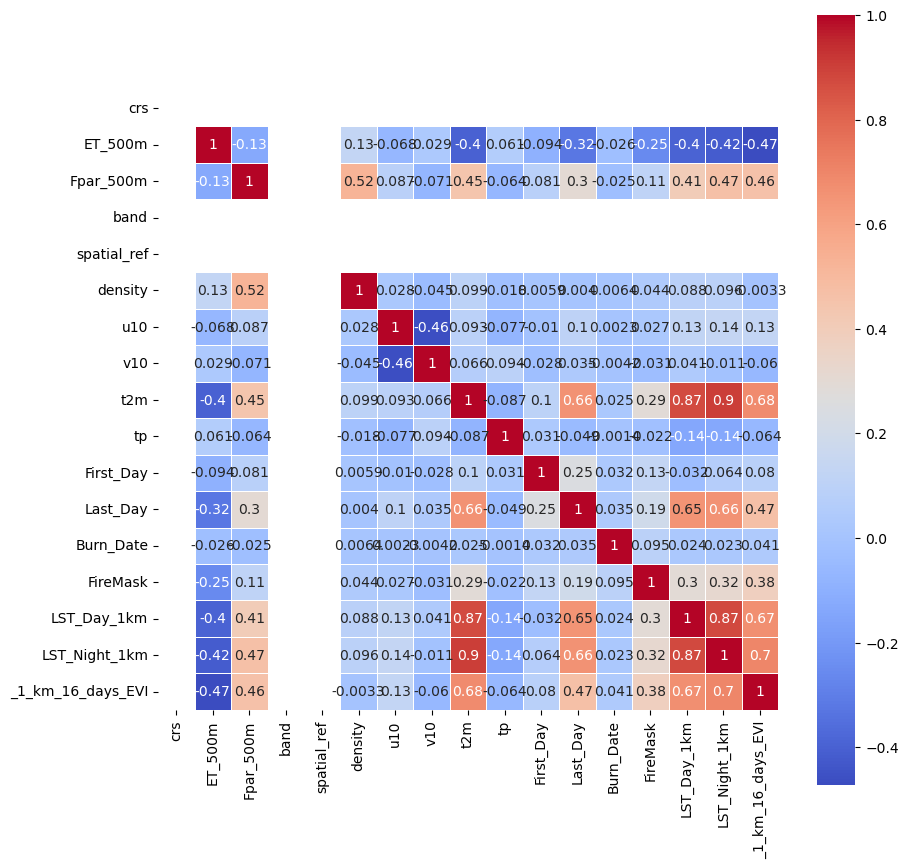

In [6]:
# Matrice des corrélations : 
cor = df.corr() 
plt.figure(figsize=(10, 10))
sns.heatmap(cor, square = True, cmap="coolwarm", linewidths=0.5, annot=True, xticklabels='auto', yticklabels='auto',)
#Pour choisr la couleur du heatmap : https://matplotlib.org/examples/color/colormaps_reference.html

In [7]:
# We drop the columns that are not relevant for the model
X = df.drop(columns = ["crs" , "band", "spatial_ref", "First_Day", "Last_Day", "Burn_Date", "FireMask"])
y = df[["FireMask"]].astype(int)
# group 7, 8 and 9 in True
y = y.replace([7, 8, 9], 1)
# group 3, 4 and 5 in False
y = y.replace([3, 4, 5], 0)
#y = y.replace(9, 7)



In [8]:
#Undersampling the dataframes to balance the classes
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X, y)
# to remark that X_res, y_res lose their original index

# Cross Validation

In [12]:
# k-fold cross validation on Logistic Regression model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

model_LR = skl.linear_model.LogisticRegression(C=0.05, l1_ratio=None, max_iter=10000)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=71)
i = 1
Accuracy_array = []
for train_index, test_index in kf.split(X_res, y_res):
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]
     
    #Train the model
    model_LR.fit(X_train, np.ravel(y_train,order='C')) #Training the model 
    
    #Evaluate the acuracy of the model
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, model_LR.predict(X_test))}, doublecheck: {model_LR.score(X_test,y_test)}")
    Accuracy_array.append(accuracy_score(y_test, model_LR.predict(X_test)))
    i += 1
Accuracy_array
# Compute the mean accuracy
print(f"Mean accuracy: {np.mean(Accuracy_array)}")

Accuracy for the fold no. 1 on the test set: 0.7010869565217391, doublecheck: 0.7010869565217391
Accuracy for the fold no. 2 on the test set: 0.7119565217391305, doublecheck: 0.7119565217391305
Accuracy for the fold no. 3 on the test set: 0.7065217391304348, doublecheck: 0.7065217391304348
Accuracy for the fold no. 4 on the test set: 0.6521739130434783, doublecheck: 0.6521739130434783
Accuracy for the fold no. 5 on the test set: 0.6521739130434783, doublecheck: 0.6521739130434783
Accuracy for the fold no. 6 on the test set: 0.6793478260869565, doublecheck: 0.6793478260869565
Accuracy for the fold no. 7 on the test set: 0.6358695652173914, doublecheck: 0.6358695652173914
Accuracy for the fold no. 8 on the test set: 0.7228260869565217, doublecheck: 0.7228260869565217
Accuracy for the fold no. 9 on the test set: 0.6684782608695652, doublecheck: 0.6684782608695652
Accuracy for the fold no. 10 on the test set: 0.7228260869565217, doublecheck: 0.7228260869565217
Mean accuracy: 0.685326086956

In [10]:
# k-fold cross validation on K-Nearst Neighbors model
from sklearn.neighbors import KNeighborsClassifier

model_KNN = skl.neighbors.KNeighborsClassifier()
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=71)
i = 1
Accuracy_array = []
for train_index, test_index in kf.split(X_res, y_res):
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]
     
    #Train the model
    model_KNN.fit(X_train, np.ravel(y_train,order='C')) #Training the model 
    
    #Evaluate the acuracy of the model
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, model_LR.predict(X_test))}, doublecheck: {model_LR.score(X_test,y_test)}")
    Accuracy_array.append(accuracy_score(y_test, model_LR.predict(X_test)))
    i += 1

# Compute the mean accuracy
print(f"Mean accuracy: {np.mean(Accuracy_array)}")

Accuracy for the fold no. 1 on the test set: 0.717391304347826, doublecheck: 0.717391304347826
Accuracy for the fold no. 2 on the test set: 0.7119565217391305, doublecheck: 0.7119565217391305
Accuracy for the fold no. 3 on the test set: 0.6413043478260869, doublecheck: 0.6413043478260869
Accuracy for the fold no. 4 on the test set: 0.6630434782608695, doublecheck: 0.6630434782608695
Accuracy for the fold no. 5 on the test set: 0.6630434782608695, doublecheck: 0.6630434782608695
Accuracy for the fold no. 6 on the test set: 0.6739130434782609, doublecheck: 0.6739130434782609
Accuracy for the fold no. 7 on the test set: 0.6304347826086957, doublecheck: 0.6304347826086957
Accuracy for the fold no. 8 on the test set: 0.717391304347826, doublecheck: 0.717391304347826
Accuracy for the fold no. 9 on the test set: 0.6847826086956522, doublecheck: 0.6847826086956522
Accuracy for the fold no. 10 on the test set: 0.7228260869565217, doublecheck: 0.7228260869565217
Mean accuracy: 0.682608695652174


In [16]:
# K-fold cross validation on random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

model_RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=71)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=71)
i = 1
Accuracy_array = []
for train_index, test_index in kf.split(X_res, y_res):
    print('Fold: {}'.format(i))
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]

    #Train the model
    model_RF.fit(X_train, np.ravel(y_train, order='C'))
    
    #Predict the response for test dataset
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, model_RF.predict(X_test))}, doublecheck: {model_RF.score(X_test,y_test)}")
    Accuracy_array.append(accuracy_score(y_test, model_RF.predict(X_test)))
    i += 1
    
# Compute the mean accuracy
print(f"Mean accuracy: {np.mean(Accuracy_array)}")

Fold: 1
Accuracy for the fold no. 1 on the test set: 0.7717391304347826, doublecheck: 0.7717391304347826
Fold: 2
Accuracy for the fold no. 2 on the test set: 0.8206521739130435, doublecheck: 0.8206521739130435
Fold: 3
Accuracy for the fold no. 3 on the test set: 0.8097826086956522, doublecheck: 0.8097826086956522
Fold: 4
Accuracy for the fold no. 4 on the test set: 0.8152173913043478, doublecheck: 0.8152173913043478
Fold: 5
Accuracy for the fold no. 5 on the test set: 0.7989130434782609, doublecheck: 0.7989130434782609
Fold: 6
Accuracy for the fold no. 6 on the test set: 0.8043478260869565, doublecheck: 0.8043478260869565
Fold: 7
Accuracy for the fold no. 7 on the test set: 0.7010869565217391, doublecheck: 0.7010869565217391
Fold: 8
Accuracy for the fold no. 8 on the test set: 0.8152173913043478, doublecheck: 0.8152173913043478
Fold: 9
Accuracy for the fold no. 9 on the test set: 0.8097826086956522, doublecheck: 0.8097826086956522
Fold: 10
Accuracy for the fold no. 10 on the test set: 

In [12]:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X_res, y_res) #, stratify= y_res) if you want preserve the same proportion of class in train and test set
#X_train 

In [13]:
# Fit the LR model
LR_model = skl.linear_model.LogisticRegression(C=0.05, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2', random_state=0,
                   tol=0.0001, verbose=0, warm_start=False).fit(X_train, np.ravel(y_train,order='C'))

In [16]:
# Predict the test set
y_pred = LR_model.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns = ["FireMask"])
y_risk = LR_model.predict_proba(X)
 
y_risk = pd.DataFrame(y_risk, columns = ["Risk_0", "Risk_1"])
#df_toplot = pd.DataFrame([X_test, y_test, y_pred, y_risk])



In [ ]:
type(y_risk.Risk_1)
y_risk = np.ravel(y_risk.Risk_1,order='C')
y_risk 

In [ ]:
df['Ta_mere'] = y_risk
df

In [ ]:

#ds.plot(column='Fpar_500m', cmap='coolwarm', legend=True, figsize=(10,10))
ds_toplot = df.to_xarray()
ds_toplot 


In [ ]:
# plot the risk map
ds['ET_500m'][1].plot()
plt.show()

In [ ]:
# Compute the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
n = y_pred.nunique()[0]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=5, color='black')
ax.set_ylabel('Actual outputs', fontsize=5, color='black')
ax.xaxis.set(ticks=range(n))
ax.yaxis.set(ticks=range(n))
ax.set_ylim(n-0.5, -0.5)
for i in range(n):
    for j in range(n):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

In [45]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.81      0.79       228
           1       0.80      0.77      0.78       232

    accuracy                           0.79       460
   macro avg       0.79      0.79      0.79       460
weighted avg       0.79      0.79      0.79       460



# KNN

In [47]:
# Fit  the KNN model
from sklearn.neighbors import KNeighborsClassifier
model_KNN = KNeighborsClassifier().fit(X_train, np.ravel(y_train,order='C'))
y_pred = model_KNN.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns = ["FireMask"])


In [ ]:
# Compute the confusion matrix

cm = confusion_matrix(y_test, y_pred)

n = y_pred.nunique()[0]

 
fig, ax = plt.subplots(figsize=(2*n, 2*n))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=5, color='black')
ax.set_ylabel('Actual outputs', fontsize=5, color='black')
ax.xaxis.set(ticks=range(n))
ax.yaxis.set(ticks=range(n))
ax.set_ylim(n-0.5, -0.5)
for i in range(n):
    for j in range(n):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()


In [ ]:
# classification report
print(classification_report(y_test, y_pred))

RAndom Forest

In [ ]:
# Fit the Random Forest model
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0).fit(X_train, np.ravel(y_train,order='C'))
y_pred = model_RF.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns = ["FireMask"])
y_pred

In [ ]:
# Compute the confusion matrix

cm = confusion_matrix(y_test, y_pred)

n = y_pred.nunique()[0]


fig, ax = plt.subplots(figsize=(2*n, 2*n))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=5, color='black')
ax.set_ylabel('Actual outputs', fontsize=5, color='black')
ax.xaxis.set(ticks=range(n))
ax.yaxis.set(ticks=range(n))
ax.set_ylim(n-0.5, -0.5)
for i in range(n):
    for j in range(n):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()



In [ ]:
# classification report
print(classification_report(y_test, y_pred))
